## Baseline Model Evaluation

This notebook evaluates the performance of two frozen baseline models, a Random
Forest regressor and a Gradient Boosting regressor, using the same train–test split
and RDKit-based molecular descriptors. The evaluation focuses on generalization
performance on a held-out test set and establishes a consistent reference point for
subsequent model and feature improvements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
import joblib

CLIP_VALUE = 1e6

In [2]:
x_test = pd.read_csv('../data/processed/x_test_proc.csv')
# x_train = pd.read_csv('../data/processed/x_train_proc.csv')
y_test = pd.read_csv('../data/processed/test_raw.csv')['Tg']
# y_train = pd.read_csv('../data/processed/train_raw.csv')['Tg']

x_test.shape, y_test.shape

((1457, 149), (1457,))

In [3]:
rf = joblib.load('../models/baseline_random_forest_model.pkl')
gbr = joblib.load('../models/baseline_gradient_boosting_model.pkl')

In [4]:
x_test.describe().loc[['min', 'max']].T.sort_values('max', ascending=False)

,min,max
Ipc,2.754888,8.363928e+46
BertzCT,0.000000,7.007009e+03
MolWt,14.027000,1.943755e+03
PEOE_VSA14,7.426653,4.432990e+02
VSA_EState1,-0.957128,4.001811e+02
...,...,...
fr_SH,0.000000,0.000000e+00
fr_HOCCN,0.000000,0.000000e+00
fr_isocyan,0.000000,0.000000e+00
fr_hdrzone,0.000000,0.000000e+00


In [5]:
x_test = x_test.clip(-CLIP_VALUE, CLIP_VALUE)

In [6]:
y_test_pred_rf = rf.predict(x_test)

y_test_pred_gbr = gbr.predict(x_test)

In [7]:
def eval_model(y_true, y_pred):
    rsme = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rsme, "R2": r2}

In [8]:
pd.DataFrame.from_dict({
    "Random Forest": eval_model(y_test, y_test_pred_rf),
    "Gradient Boosting": eval_model(y_test, y_test_pred_gbr)
}, orient='index')

,RMSE,R2
Random Forest,39.918709,0.875081
Gradient Boosting,43.699538,0.850298


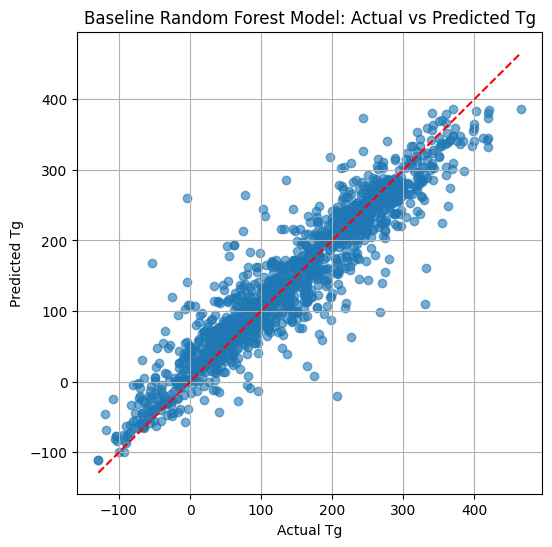

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Tg')
plt.ylabel('Predicted Tg')
plt.title('Baseline Random Forest Model: Actual vs Predicted Tg')  
plt.grid(True)
plt.show()

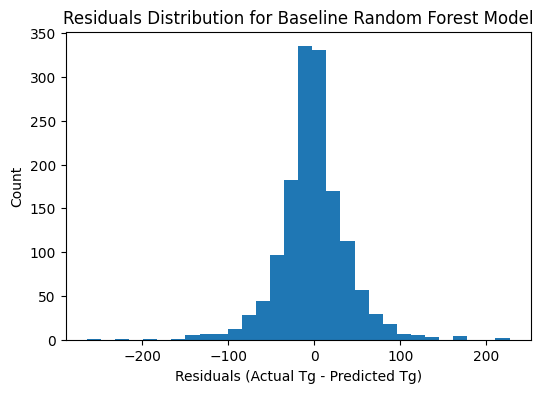

In [10]:
residuals = y_test - y_test_pred_rf
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel('Residuals (Actual Tg - Predicted Tg)')
plt.ylabel('Count')
plt.title('Residuals Distribution for Baseline Random Forest Model')
plt.show()

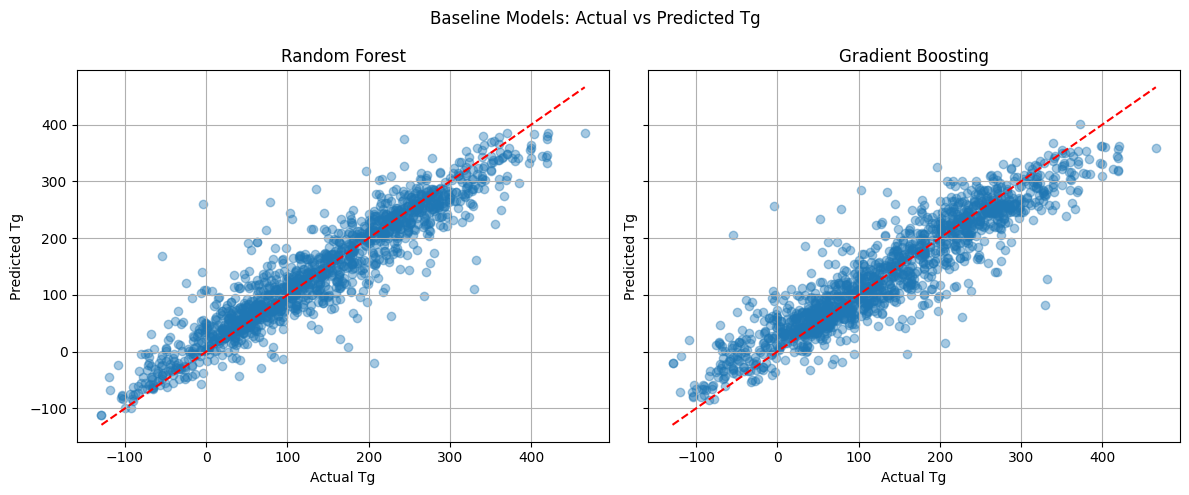

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

models = {
    "Random Forest": y_test_pred_rf,
    "Gradient Boosting": y_test_pred_gbr
}

for ax, (name, y_pred) in zip(axes, models.items()):
    ax.scatter(y_test, y_pred, alpha=0.4)
    min_val, max_val = y_test.min(), y_test.max()
    ax.plot([min_val, max_val], [min_val, max_val], "r--")
    ax.set_title(name)
    ax.set_xlabel("Actual Tg")
    ax.set_ylabel("Predicted Tg")
    ax.grid(True)

plt.suptitle("Baseline Models: Actual vs Predicted Tg")
plt.tight_layout()
plt.show()

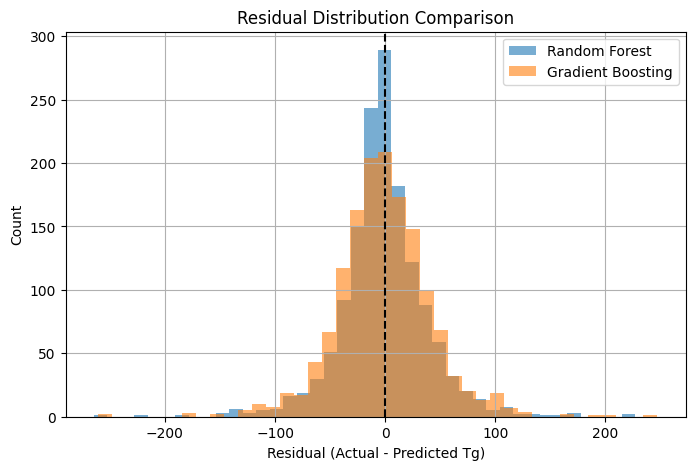

In [12]:
plt.figure(figsize=(8, 5))

plt.hist(y_test - y_test_pred_rf, bins=40, alpha=0.6, label="Random Forest")
plt.hist(y_test - y_test_pred_gbr, bins=40, alpha=0.6, label="Gradient Boosting")

plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Residual (Actual - Predicted Tg)")
plt.ylabel("Count")
plt.title("Residual Distribution Comparison")
plt.legend()
plt.grid(True)
plt.show()

## Baseline Evaluation Summary

The baseline Random Forest and Gradient Boosting models demonstrate reasonable predictive performance
on the held-out test set.

- The RMSE and R² values indicate that the model captures meaningful relationships
  between molecular descriptors and glass transition temperature (Tg).
- A generalization gap between training and test performance is expected and
  suggests no obvious data leakage.
- Prediction scatter and residual distributions show no strong systematic bias.

This baseline result serves as a reference point for future model development,
including alternative feature representations and more advanced models.


## Baseline Model Performance

Two tree-based ensemble models were evaluated using the same frozen RDKit descriptor
representation and train–test split. The Random Forest baseline achieved an RMSE of
approximately 40 K with an R² of 0.88, providing a strong reference for Tg prediction.

The Gradient Boosting model, trained as a second baseline under conservative
regularization settings, showed slightly higher error (RMSE ≈ 44 K, R² ≈ 0.85).
This difference suggests that bagging-based ensembles may be more robust than
boosting-based approaches for high-dimensional, noisy polymer descriptor spaces.

Despite the performance gap, both models exhibit strong linear correlation between
predicted and actual Tg values, with no obvious systematic bias observed in residual
distributions. These results establish a reliable baseline benchmark and motivate
future exploration of polymer-aware features and alternative boosting frameworks.


**Baseline winner:** Random Forest

Random Forest outperformed Gradient Boosting under the same frozen RDKit descriptor
setup, achieving lower RMSE and higher R² on the test set. This suggests stronger
robustness to noise in high-dimensional polymer descriptor spaces, making Random
Forest the most reliable baseline reference for future model improvements.
